# Install and import packages

In [1]:
# Install normflow (takes approx 8 seconds to run)
!pip install --upgrade git+https://github.com/VincentStimper/normalizing-flows.git

  Cloning https://github.com/VincentStimper/normalizing-flows.git to /tmp/pip-req-build-olgeol2e
  Running command git clone -q https://github.com/VincentStimper/normalizing-flows.git /tmp/pip-req-build-olgeol2e
  Cloning https://github.com/VincentStimper/residual-flows.git to /tmp/pip-install-ixgjamq4/residual-flows_323e57998ef648b5becb12de4ae8c70b
  Running command git clone -q https://github.com/VincentStimper/residual-flows.git /tmp/pip-install-ixgjamq4/residual-flows_323e57998ef648b5becb12de4ae8c70b
  Created wheel for normflow: filename=normflow-1.2-py2.py3-none-any.whl size=60862 sha256=6e96a7064a986fa2992a466d119818022c6407fe2c6b78f483a8c788da93f8cd
  Stored in directory: /tmp/pip-ephem-wheel-cache-n5iallog/wheels/d9/40/c8/9ac98610e01d078086ad1abd95cd552ce5eef5bec50c647dd5
  Created wheel for residual-flows: filename=residual_flows-1.0-py2.py3-none-any.whl size=36203 sha256=53fba710a1a766f5bf3ffc88a175bfd60917fcd8fd524b16b5056e7fe3cacdf8
  Stored in directory: /tmp/pip-ephem-wh

In [2]:
# Install Openmm (takes approx 5 minutes to run)
import sys
print(sys.version)
!wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.10.3-Linux-x86_64.sh
!bash Miniconda3-py*.sh -bfp /usr/local
!conda config --set always_yes yes
!conda config --add channels conda-forge
!conda create -n openmm python=3.7 cudatoolkit=10.0 git jupyterlab matplotlib ipympl rdkit openbabel openmm mdtraj pymbar pdbfixer parmed openff-toolkit openmoltools openmmforcefields
sys.path.append('/usr/local/envs/openmm/lib/python3.7/site-packages')
import openmm.testInstallation
openmm.testInstallation.main()

3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]
--2022-05-10 03:04:55--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.10.3-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 89026327 (85M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.10.3-Linux-x86_64.sh’

Miniconda3-py37_4.1 100%[===================>]  84.90M   183MB/s    in 0.5s    

2022-05-10 03:04:56 (183 MB/s) - ‘Miniconda3-py37_4.10.3-Linux-x86_64.sh’ saved [89026327/89026327]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - \ | / done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - _openmp_mutex==4.5=1_gnu
    - brotlipy==0.7.0=py37h27cfd23_1003
    - ca-certificates==2021.7.5=h06a4308_1
    - certifi==2021.5.30=p

In [3]:
# Import Openmm, matplotlib
from sys import stdout

import matplotlib.pyplot as plt
#import mdtraj
#import pandas
#%matplotlib widget
from openmm import *
from openmm.app import *
from openmm.unit import *

In [4]:
# Import numpy, scipy, normflow
import numpy as np
import normflow as nf
from tqdm import tqdm

# For math and stats operations
from scipy.spatial.transform import Rotation as R
from scipy.stats import multivariate_normal
#import plotly.graph_objs as go
#import plotly

# For saving and loading
import pickle
%matplotlib inline

In [5]:
# Import pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [66]:
# Frequently used definitions
dtype = torch.FloatTensor
enable_cuda = False
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')

pdbfile = 'alanine-dipeptide.pdb'
num_atoms = 22
forcefile = 'amber14-all.xml'

pklfile = 'aldip_img1024_dim51_nse1_scl0.001_q1.pkl'
num_imgs = 64 #1024
n_cells = 51
noise_sigma = 1
blob_sigma = 0.001
Q = 1

num_flows = 5
beta = 1.0
num_epochs = 1000

kB = 1.3807e-26
Avo = 6.0221408e+23
T = 300
kBxAvoxT = kB*Avo*T
print(kBxAvoxT)

2.4944309407680003


# Load images and define backpropagable potential energy function

In [7]:
pdb = PDBFile(pdbfile)
forcefield = ForceField(forcefile)
system = forcefield.createSystem(pdb.topology, nonbondedCutoff=3*nanometer, constraints=HBonds)
integrator = LangevinIntegrator(T*kelvin, 1/picosecond, 2*femtoseconds)
simulation = Simulation(pdb.topology, system, integrator)
simulation.context.setPositions(pdb.positions)
simulation.minimizeEnergy()
#simulation.reporters.append(PDBReporter('output.pdb', 1000))
#simulation.reporters.append(StateDataReporter(stdout, 1000, step=True, volume=True, density=True,
#        potentialEnergy=True, temperature=True))

for i in range(1):
    simulation.step(1000)
    state0 = simulation.context.getState(getPositions=True, getForces=True, getEnergy=True)

    print("Potential energy")
    print(state0.getPotentialEnergy())

    print("Atomic positions")
    print(state0.getPositions(asNumpy=True))

    print("Volume")
    print(state0.getPeriodicBoxVolume())

    print("Forces")
    print(state0.getForces(asNumpy=True))

Potential energy
-24.869293212890625 kJ/mol
Atomic positions
[[ 0.08444528  0.39079157  0.05018006]
 [ 0.12018407  0.32067782 -0.02523791]
 [ 0.09240136  0.37301415 -0.11672583]
 [ 0.08141358  0.21930629 -0.01515505]
 [ 0.26634103  0.32122466 -0.00963441]
 [ 0.3222661   0.21172172  0.00725147]
 [ 0.33640376  0.43293455 -0.03383241]
 [ 0.29238892  0.50952947 -0.08279122]
 [ 0.484799    0.4458954  -0.02273809]
 [ 0.51997381  0.38576537  0.06109582]
 [ 0.55083674  0.38701433 -0.14933245]
 [ 0.52573824  0.44959709 -0.23497395]
 [ 0.65846986  0.39416522 -0.1336799 ]
 [ 0.52447224  0.2823979  -0.16486679]
 [ 0.52593297  0.58929569 -0.00670362]
 [ 0.47486755  0.67738765 -0.07552499]
 [ 0.62553698  0.60972106  0.07919698]
 [ 0.65772122  0.52501231  0.12380192]
 [ 0.68097657  0.7478587   0.11378676]
 [ 0.72545749  0.80319214  0.03107786]
 [ 0.59036738  0.80635792  0.12956171]
 [ 0.74995852  0.73271292  0.19681142]] nm
Volume
8.0 nm**3
Forces
[[ -275.44644248  -524.99610186   282.90170383]
 [ -7

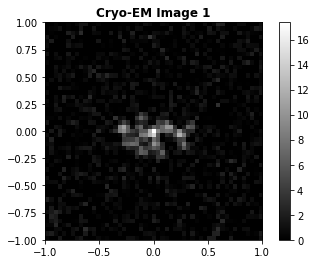

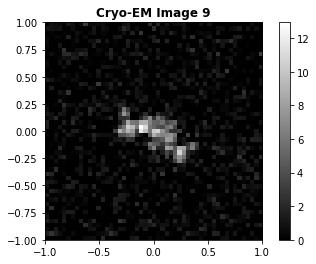

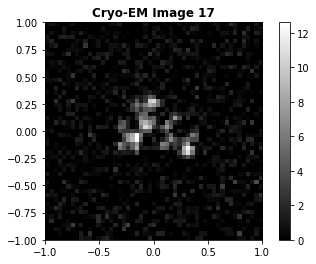

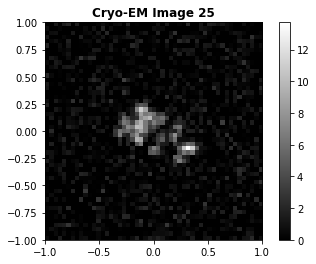

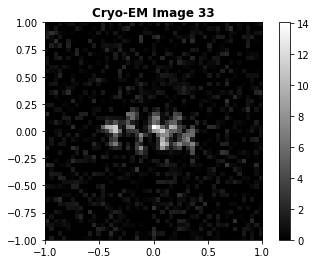

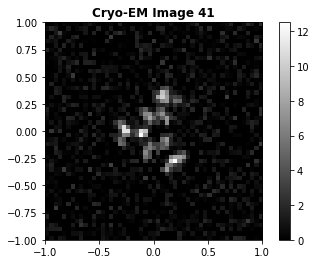

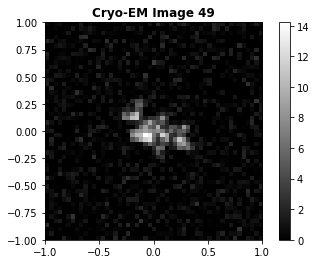

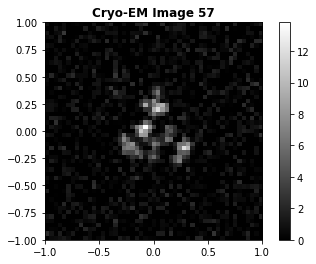

In [15]:
with open(pklfile, 'rb') as inp:
    rot_mats = pickle.load(inp)[0:num_imgs]
    pot_energies = pickle.load(inp)[0:num_imgs]
    forces_list = pickle.load(inp)[0:num_imgs]
    pos_list = pickle.load(inp)[0:num_imgs]
    img_list = pickle.load(inp)[0:num_imgs]

for idx, img in enumerate(img_list):
    if idx % 8 == 0:
        c = plt.imshow(img, cmap ='gray', vmin = 0, vmax = np.abs(img).max(),\
                        extent = [-Q, Q, -Q, Q], interpolation = 'nearest', origin = 'lower')
        plt.colorbar(c)

        plt.title(f'Cryo-EM Image {idx+1}', fontweight = "bold")
        plt.show()

In [67]:
class pot_energy(torch.autograd.Function):
    """
    We can implement our own custom autograd Functions by subclassing
    torch.autograd.Function and implementing the forward and backward passes
    which operate on Tensors.
    """

    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we receive a Tensor containing the input and return
        a Tensor containing the output. ctx is a context object that can be used
        to stash information for backward computation. You can cache arbitrary
        objects for use in the backward pass using the ctx.save_for_backward method.
        """
        reshaped_input = input.reshape(22, 3)
        ctx.save_for_backward(reshaped_input)

        simulation.context.setPositions(reshaped_input.cpu().numpy())
        state = simulation.context.getState(getPositions=True, getForces=True, getEnergy=True)
        return torch.tensor(state.getPotentialEnergy()._value).to(device)

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
        """
        reshaped_input, = ctx.saved_tensors

        simulation.context.setPositions(reshaped_input.cpu().numpy())
        state = simulation.context.getState(getPositions=True, getForces=True, getEnergy=True)
        return -grad_output * torch.tensor(state.getForces(asNumpy=True)._value).reshape(-1, 22*3).to(device)

In [68]:
def torch_createblobs(coords, Q=Q, n_cells=n_cells, blob_sigma=blob_sigma, rot_mat=torch.eye(3)):
    # Grids of x and y points
    x = torch.linspace(-Q, Q, n_cells, device=device)
    y = torch.linspace(-Q, Q, n_cells, device=device)
    # Create a 2-D meshgrid of (x, y) coordinates.
    x, y = torch.meshgrid(x, y, indexing='xy')

    normals = torch.zeros_like(x, device=device)

    # Creating mixture of gaussians
    pos = torch.empty(x.shape + (2,), device=device).double()
    pos[:, :, 0] = x
    pos[:, :, 1] = y

    new_coords = coords @ rot_mat.T

    for row in new_coords.double():
        var = torch.distributions.multivariate_normal.MultivariateNormal(row[0:2], blob_sigma*torch.eye(2, device=device).double())
        normals = normals + torch.exp(var.log_prob(pos))

    return normals/len(new_coords)

# NF Pipeline

In [75]:
# Fixing template, latent vectors, and flows
x0 = torch.tensor(state0.getPositions(asNumpy=True)._value).to(device)
loss_hist = []

latentvecs = []
latentvec_logprobs = []
var = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(num_atoms*3).to(device), torch.eye(num_atoms*3).to(device))

for _ in range(num_imgs):
    latentvecs.append(torch.randn_like(x0).reshape(-1, num_atoms*3).type(dtype).to(device))
    latentvec_logprobs.append(var.log_prob(latentvecs[-1]))

flows = []
for _ in range(num_flows):
    flows += [nf.flows.Planar((num_atoms*3,)).to(device)]

In [76]:
class nfmodel(nn.Module):
    def __init__(self, flows = flows, noise_sigma = noise_sigma, template = x0):
        super().__init__()

        self.flows = nn.ModuleList(flows)
        self.noise_sigma = noise_sigma
        self.template = template

        #self.mlp = nn.Sequential(
        #    nn.Linear(num_atoms*3, 16),
        #    nn.Tanh(),
        #    nn.Linear(16, num_atoms*3))


    def forward(self, z):
        for flow in self.flows:
            z, _ = flow(z)

        return self.template + z.reshape(22, 3)


    def reverse_kl(self, z, logprob_z, target, rot_mat, beta = beta):
        log_q = 0#logprob_z

        for flow in self.flows:
            z, log_det = flow(z)
            log_q -= log_det

        recons_coords = self.template + z.reshape(22, 3)
        img_mseloss = torch.norm(target - torch_createblobs(recons_coords, rot_mat = rot_mat))**2
        return pot_energy.apply(recons_coords.reshape(-1, 22*3))/kBxAvoxT + log_q +\
                    beta * img_mseloss/(2*self.noise_sigma**2)


model = nfmodel(flows = flows).to(device)

In [77]:
#criterion = pot_energy.apply
#outputs = []

optimizer = torch.optim.Adam(model.parameters(),
                             lr=2e-2, 
                             weight_decay=1e-5)


for epoch in tqdm(range(num_epochs)):
    loss = 0
    for latentvec, latentvec_logprob, target, rot_mat in zip(latentvecs, latentvec_logprobs, img_list, rot_mats):
        loss += model.reverse_kl(latentvec, latentvec_logprob, torch.from_numpy(target).to(device), torch.from_numpy(rot_mat).to(device))
            
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')

    loss_hist.append(loss.cpu().data.numpy())

  0%|          | 1/1000 [00:02<34:09,  2.05s/it]

Epoch:1, Loss:509034240.0000


  1%|          | 11/1000 [00:21<32:32,  1.97s/it]

Epoch:11, Loss:188850848.0000


  2%|▏         | 21/1000 [00:41<32:12,  1.97s/it]

Epoch:21, Loss:301856960.0000


  3%|▎         | 31/1000 [01:01<31:48,  1.97s/it]

Epoch:31, Loss:269838496.0000


  4%|▍         | 41/1000 [01:20<30:53,  1.93s/it]

Epoch:41, Loss:257594512.0000


  5%|▌         | 51/1000 [01:40<31:49,  2.01s/it]

Epoch:51, Loss:388250912.0000


  6%|▌         | 61/1000 [02:00<31:00,  1.98s/it]

Epoch:61, Loss:430877408.0000


  7%|▋         | 71/1000 [02:20<30:38,  1.98s/it]

Epoch:71, Loss:338882848.0000


  8%|▊         | 81/1000 [02:40<30:33,  2.00s/it]

Epoch:81, Loss:283843680.0000


  9%|▉         | 91/1000 [02:59<29:41,  1.96s/it]

Epoch:91, Loss:254352448.0000


 10%|█         | 101/1000 [03:19<29:10,  1.95s/it]

Epoch:101, Loss:236796448.0000


 11%|█         | 111/1000 [03:38<29:07,  1.97s/it]

Epoch:111, Loss:226650832.0000


 12%|█▏        | 121/1000 [03:58<28:45,  1.96s/it]

Epoch:121, Loss:219171616.0000


 13%|█▎        | 131/1000 [04:18<28:36,  1.98s/it]

Epoch:131, Loss:215146880.0000


 14%|█▍        | 141/1000 [04:37<27:54,  1.95s/it]

Epoch:141, Loss:211916240.0000


 15%|█▌        | 151/1000 [04:57<28:11,  1.99s/it]

Epoch:151, Loss:209269904.0000


 16%|█▌        | 161/1000 [05:17<28:00,  2.00s/it]

Epoch:161, Loss:207127520.0000


 17%|█▋        | 171/1000 [05:37<27:23,  1.98s/it]

Epoch:171, Loss:205302048.0000


 18%|█▊        | 181/1000 [05:57<27:12,  1.99s/it]

Epoch:181, Loss:203885184.0000


 19%|█▉        | 191/1000 [06:16<26:15,  1.95s/it]

Epoch:191, Loss:202211024.0000


 20%|██        | 201/1000 [06:36<26:06,  1.96s/it]

Epoch:201, Loss:200688576.0000


 21%|██        | 211/1000 [06:56<25:50,  1.97s/it]

Epoch:211, Loss:199295744.0000


 22%|██▏       | 221/1000 [07:16<25:39,  1.98s/it]

Epoch:221, Loss:198089760.0000


 23%|██▎       | 231/1000 [07:35<25:27,  1.99s/it]

Epoch:231, Loss:196979184.0000


 24%|██▍       | 241/1000 [07:55<25:08,  1.99s/it]

Epoch:241, Loss:195926448.0000


 25%|██▌       | 251/1000 [08:15<25:09,  2.01s/it]

Epoch:251, Loss:194898512.0000


 26%|██▌       | 261/1000 [08:35<24:24,  1.98s/it]

Epoch:261, Loss:193868976.0000


 27%|██▋       | 271/1000 [08:55<24:05,  1.98s/it]

Epoch:271, Loss:192818560.0000


 28%|██▊       | 281/1000 [09:14<23:30,  1.96s/it]

Epoch:281, Loss:191739040.0000


 29%|██▉       | 291/1000 [09:34<23:18,  1.97s/it]

Epoch:291, Loss:190664336.0000


 30%|███       | 301/1000 [09:54<23:13,  1.99s/it]

Epoch:301, Loss:189607936.0000


 31%|███       | 311/1000 [10:14<22:48,  1.99s/it]

Epoch:311, Loss:188612112.0000


 32%|███▏      | 321/1000 [10:34<22:34,  1.99s/it]

Epoch:321, Loss:187782976.0000


 33%|███▎      | 331/1000 [10:54<22:03,  1.98s/it]

Epoch:331, Loss:187068240.0000


 34%|███▍      | 341/1000 [11:13<21:13,  1.93s/it]

Epoch:341, Loss:186357104.0000


 35%|███▌      | 351/1000 [11:33<21:07,  1.95s/it]

Epoch:351, Loss:185669680.0000


 36%|███▌      | 361/1000 [11:53<21:07,  1.98s/it]

Epoch:361, Loss:184995392.0000


 37%|███▋      | 371/1000 [12:12<20:29,  1.96s/it]

Epoch:371, Loss:184341520.0000


 38%|███▊      | 381/1000 [12:32<20:12,  1.96s/it]

Epoch:381, Loss:183727680.0000


 39%|███▉      | 391/1000 [12:52<20:03,  1.98s/it]

Epoch:391, Loss:183161040.0000


 40%|████      | 401/1000 [13:12<19:38,  1.97s/it]

Epoch:401, Loss:182641504.0000


 41%|████      | 411/1000 [13:32<19:32,  1.99s/it]

Epoch:411, Loss:182150368.0000


 42%|████▏     | 421/1000 [13:51<19:09,  1.98s/it]

Epoch:421, Loss:181671136.0000


 43%|████▎     | 431/1000 [14:11<18:37,  1.96s/it]

Epoch:431, Loss:181200304.0000


 44%|████▍     | 441/1000 [14:30<18:09,  1.95s/it]

Epoch:441, Loss:180737728.0000


 45%|████▌     | 451/1000 [14:50<18:03,  1.97s/it]

Epoch:451, Loss:180286736.0000


 46%|████▌     | 461/1000 [15:10<17:35,  1.96s/it]

Epoch:461, Loss:179854080.0000


 47%|████▋     | 471/1000 [15:29<17:17,  1.96s/it]

Epoch:471, Loss:179445376.0000


 48%|████▊     | 481/1000 [15:49<16:58,  1.96s/it]

Epoch:481, Loss:179060240.0000


 49%|████▉     | 491/1000 [16:09<16:46,  1.98s/it]

Epoch:491, Loss:178693904.0000


 50%|█████     | 501/1000 [16:28<16:21,  1.97s/it]

Epoch:501, Loss:178341984.0000


 51%|█████     | 511/1000 [16:48<15:59,  1.96s/it]

Epoch:511, Loss:178001168.0000


 52%|█████▏    | 521/1000 [17:08<15:32,  1.95s/it]

Epoch:521, Loss:177669056.0000


 53%|█████▎    | 531/1000 [17:27<15:25,  1.97s/it]

Epoch:531, Loss:177343728.0000


 54%|█████▍    | 541/1000 [17:47<14:46,  1.93s/it]

Epoch:541, Loss:177023424.0000


 55%|█████▌    | 551/1000 [18:06<14:31,  1.94s/it]

Epoch:551, Loss:176706832.0000


 56%|█████▌    | 561/1000 [18:26<14:04,  1.92s/it]

Epoch:561, Loss:176392736.0000


 57%|█████▋    | 571/1000 [18:45<14:15,  1.99s/it]

Epoch:571, Loss:176078944.0000


 58%|█████▊    | 581/1000 [19:05<13:42,  1.96s/it]

Epoch:581, Loss:175764224.0000


 59%|█████▉    | 591/1000 [19:25<13:30,  1.98s/it]

Epoch:591, Loss:175446960.0000


 60%|██████    | 601/1000 [19:45<13:14,  1.99s/it]

Epoch:601, Loss:175125888.0000


 61%|██████    | 611/1000 [20:04<12:49,  1.98s/it]

Epoch:611, Loss:174799712.0000


 62%|██████▏   | 621/1000 [20:24<12:33,  1.99s/it]

Epoch:621, Loss:174467408.0000


 63%|██████▎   | 631/1000 [20:44<12:18,  2.00s/it]

Epoch:631, Loss:174127920.0000


 64%|██████▍   | 641/1000 [21:04<11:55,  1.99s/it]

Epoch:641, Loss:173780896.0000


 65%|██████▌   | 651/1000 [21:24<11:22,  1.96s/it]

Epoch:651, Loss:173425264.0000


 66%|██████▌   | 661/1000 [21:43<11:04,  1.96s/it]

Epoch:661, Loss:173059648.0000


 67%|██████▋   | 671/1000 [22:03<10:43,  1.96s/it]

Epoch:671, Loss:172682608.0000


 68%|██████▊   | 681/1000 [22:23<10:35,  1.99s/it]

Epoch:681, Loss:172292560.0000


 69%|██████▉   | 691/1000 [22:42<10:08,  1.97s/it]

Epoch:691, Loss:171887760.0000


 70%|███████   | 701/1000 [23:02<09:37,  1.93s/it]

Epoch:701, Loss:171466368.0000


 71%|███████   | 711/1000 [23:22<09:38,  2.00s/it]

Epoch:711, Loss:171026176.0000


 72%|███████▏  | 721/1000 [23:42<09:19,  2.01s/it]

Epoch:721, Loss:170565616.0000


 73%|███████▎  | 731/1000 [24:02<08:56,  1.99s/it]

Epoch:731, Loss:170086224.0000


 74%|███████▍  | 741/1000 [24:21<08:27,  1.96s/it]

Epoch:741, Loss:169591056.0000


 75%|███████▌  | 751/1000 [24:41<08:17,  2.00s/it]

Epoch:751, Loss:169083280.0000


 76%|███████▌  | 761/1000 [25:01<07:50,  1.97s/it]

Epoch:761, Loss:168561344.0000


 77%|███████▋  | 771/1000 [25:20<07:25,  1.95s/it]

Epoch:771, Loss:168020880.0000


 78%|███████▊  | 781/1000 [25:40<07:11,  1.97s/it]

Epoch:781, Loss:167461376.0000


 79%|███████▉  | 791/1000 [26:00<06:52,  1.97s/it]

Epoch:791, Loss:166882624.0000


 80%|████████  | 801/1000 [26:20<06:32,  1.97s/it]

Epoch:801, Loss:166286288.0000


 81%|████████  | 811/1000 [26:39<06:10,  1.96s/it]

Epoch:811, Loss:165675600.0000


 82%|████████▏ | 821/1000 [26:59<05:51,  1.96s/it]

Epoch:821, Loss:165056736.0000


 83%|████████▎ | 831/1000 [27:19<05:32,  1.97s/it]

Epoch:831, Loss:164438352.0000


 84%|████████▍ | 841/1000 [27:38<05:13,  1.97s/it]

Epoch:841, Loss:163809200.0000


 85%|████████▌ | 851/1000 [27:58<04:51,  1.96s/it]

Epoch:851, Loss:163162736.0000


 86%|████████▌ | 861/1000 [28:18<04:33,  1.97s/it]

Epoch:861, Loss:162474096.0000


 87%|████████▋ | 871/1000 [28:37<04:14,  1.97s/it]

Epoch:871, Loss:161847696.0000


 88%|████████▊ | 881/1000 [28:57<03:52,  1.96s/it]

Epoch:881, Loss:161243792.0000


 89%|████████▉ | 891/1000 [29:17<03:32,  1.95s/it]

Epoch:891, Loss:160653744.0000


 90%|█████████ | 901/1000 [29:36<03:12,  1.95s/it]

Epoch:901, Loss:160060512.0000


 91%|█████████ | 911/1000 [29:56<02:52,  1.94s/it]

Epoch:911, Loss:159226592.0000


 92%|█████████▏| 921/1000 [30:15<02:33,  1.94s/it]

Epoch:921, Loss:158647632.0000


 93%|█████████▎| 931/1000 [30:34<02:12,  1.93s/it]

Epoch:931, Loss:158020720.0000


 94%|█████████▍| 941/1000 [30:54<01:53,  1.93s/it]

Epoch:941, Loss:157435840.0000


 95%|█████████▌| 951/1000 [31:13<01:36,  1.96s/it]

Epoch:951, Loss:156856208.0000


 96%|█████████▌| 961/1000 [31:33<01:16,  1.96s/it]

Epoch:961, Loss:156282272.0000


 97%|█████████▋| 971/1000 [31:52<00:56,  1.95s/it]

Epoch:971, Loss:155709872.0000


 98%|█████████▊| 981/1000 [32:12<00:36,  1.93s/it]

Epoch:981, Loss:155130800.0000


 99%|█████████▉| 991/1000 [32:31<00:17,  1.94s/it]

Epoch:991, Loss:154540416.0000


100%|██████████| 1000/1000 [32:49<00:00,  1.97s/it]


In [82]:
#simulation.context.setPositions(pdb.positions)

print(x0 + model.forward(latentvecs[1]))
print(pos_list[1])

tensor([[ 1.2828,  1.4720, -0.1343],
        [-0.1165,  1.0385, -0.3758],
        [-2.9789, -0.7069,  0.4361],
        [ 0.2533, -0.4643, -1.8830],
        [ 1.7963,  0.9419,  0.0766],
        [-1.6535,  0.0786,  1.1867],
        [ 1.4544,  1.3783, -1.8017],
        [ 0.9370, -0.8863, -1.0940],
        [-0.1158,  0.7550, -1.3872],
        [ 4.8465, -0.1158, -3.0337],
        [-0.4981, -0.8771, -1.1520],
        [ 2.9018,  2.1730, -1.5226],
        [ 1.0577, -2.6747, -0.8415],
        [ 1.2647,  2.1392,  3.8213],
        [ 1.0467,  0.1430, -1.5722],
        [-0.1275,  1.4588, -0.1525],
        [ 1.6458,  1.9005, -0.0416],
        [-0.3307,  2.8152, -0.3248],
        [ 1.1337,  0.8964, -1.8116],
        [ 0.0209,  1.1647, -1.8872],
        [ 3.2607, -2.0948, -1.9099],
        [ 1.7667,  7.1177,  0.8426]], dtype=torch.float64,
       grad_fn=<AddBackward0>)
[[-0.28399953 -0.12669724 -0.23203991]
 [-0.28301755 -0.11767898 -0.12341804]
 [-0.24640079 -0.21165304 -0.08207689]
 [-0.38526371 -0